In [1]:
# %pip install pydiscourse
# %pip install openpyxl

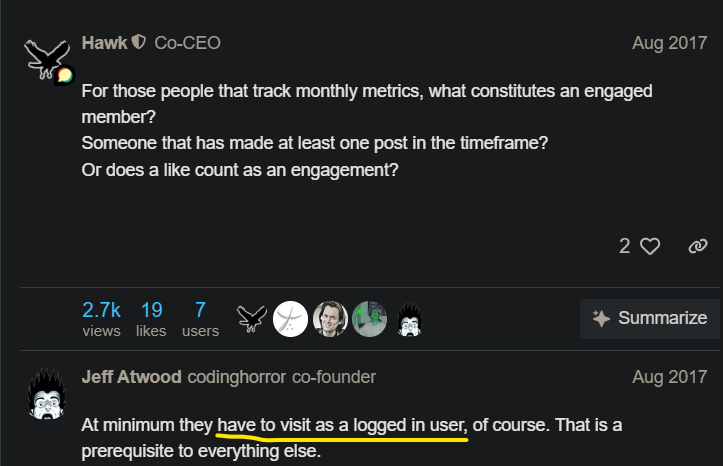
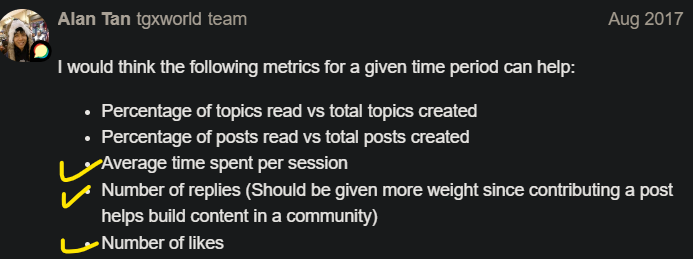

The discussion on the page(https://meta.discourse.org/t/what-does-engaged-mean-in-your-community/67751/17) revolves around defining what it means for a member to be "engaged" in a community. Different users share their perspectives on metrics that indicate engagement, such as the number of posts, likes, read time, and other interactions. The consensus seems to be that engagement can vary depending on the community, but generally, it involves **more active participation like posting and replying, rather than just passive actions like reading or liking posts.**

In summary, while there isn't a one-size-fits-all definition, **an engaged member is typically someone who actively contributes to the community through posts, replies, and other meaningful interactions. Passive actions like reading and liking are also considered, but they may not be sufficient on their own to classify a member as fully engaged.**

Your read time on a Discourse forum **will not keep getting counted if you switch to another tab** (like YouTube) and stop actively engaging with the forum. Discourse tracks read time using various mechanisms, such as detecting active scrolling, mouse movements, and keyboard interactions. If the browser tab becomes inactive or there are no signs of user activity, the read time counter typically pauses.

### Key Points on Discourse Read Time:
1. **Active Engagement Required**: Discourse requires some form of interaction (e.g., scrolling or mouse movements) to count read time. Simply keeping the tab open without activity won't count.
2. **Tab Inactivity Detection**: Modern web browsers can detect whether a tab is active or in the background. Discourse likely uses this information to stop counting read time if the tab is not in focus.
3. **Session Timeouts**: Discourse might also stop counting after a specific period of inactivity, even if the tab remains open.

If you want to verify this behavior on a specific forum, you could experiment by checking your profile's "read time" metric before and after performing such an action.

Also I am thinking that since we want to normalise engagement score wrt different subjects because BDM will obviously have much lesser engagement compared to somwething like DBMS or MLT **we can count the number of posts in a subject and then divide the engagement score by the number of posts in that subject**. This will give us a normalised engagement score for each subject.

In [30]:
import requests,json, time
from pprint import pprint
import pandas as pd

# Get the API key and username from yaml

import yaml
with open("key.yaml", "r") as file:
    api_keys = yaml.safe_load(file)

api_key = api_keys["API_KEY"]
api_username = "ShubhamG"
defaultHost = "discourse.onlinedegree.iitm.ac.in"

# Headers for authentication
headers = {
    'Api-Key': api_key,
    'Api-Username': api_username
}

In [37]:
# Get the first dataframe of user information
df_user_info = pd.read_csv('./USER_ACTIONS/user_actions.csv')
df_user_info.sample(4)

,subject,user,likes_given,likes_recieved,created_a_new_topic,replied,user's_post_was_quoted,user_marked_a_post_as_solution,Solutions_posted
0,dlp,man,8,335,16,259,1,54,58
8,mlt,Vishal,335,520,21,567,0,84,84
2,dlp,21f3002073,33,213,16,179,2,23,23
6,mlt,Nikita,439,1108,26,1053,8,188,189


In [32]:
# Second dataframe of subject information
df_subject = pd.read_csv('./Subject_specifics/total_posts_per_subject.csv')
df_subject

,subject,total_topics
0,mlt,191
1,maths2,347
2,dlp,107


In [33]:
# Now left-outer join the two tables on the 'subject' column
merged_df = pd.merge(df_user_info, df_subject, on='subject', how='left')

# Rename the "total_topics" column to "overall_topics_count_of_this_subject"
merged_df.rename(columns={'total_topics': 'overall_topics_count_of_this_subject'}, inplace=True)
# Display the updated DataFrame
merged_df

,subject,user,likes_given,likes_recieved,created_a_new_topic,replied,user's_post_was_quoted,user_marked_a_post_as_solution,Solutions_posted,overall_topics_count_of_this_subject
0,dlp,man,8,335,16,259,1,54,58,107
1,dlp,pkrishna,0,0,0,1,0,0,0,107
2,dlp,21f3002073,33,213,16,179,2,23,23,107
3,maths2,lavanya,0,14,2,1,0,1,1,347
4,maths2,Sannidhi_Alape,0,0,0,1,0,1,1,347
5,mlt,23f2000573,137,371,40,599,1,71,80,191
6,mlt,Nikita,439,1108,26,1053,8,188,189,191
7,mlt,PulkitMangal,86,578,75,938,0,174,187,191
8,mlt,Vishal,335,520,21,567,0,84,84,191


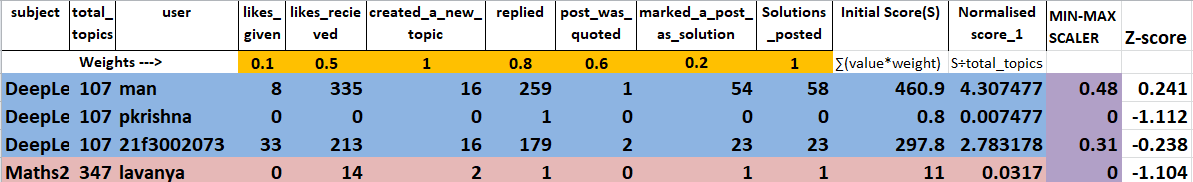

In [34]:
# Assign the weights to the relevant columns
weights_dict = { 'likes_given': 0.1,
                "likes_recieved": 0.5,
                "created_a_new_topic": 1,
                "replied": 0.8,
                "user's_post_was_quoted": 0.6,
                "user_marked_a_post_as_solution":0.2,
                "Solutions_posted": 1
}
merged_df.columns


Index(['subject', 'user', 'likes_given', 'likes_recieved',
       'created_a_new_topic', 'replied', 'user's_post_was_quoted',
       'user_marked_a_post_as_solution', 'Solutions_posted',
       'overall_topics_count_of_this_subject'],
      dtype='object')

In [35]:
# Initial score is the summation of column_value*weight
merged_df["initial_score"] = sum(merged_df[column]*weights_dict[column] for column in merged_df.columns if column not in ["initial_score",'subject','user','overall_topics_count_of_this_subject'])

# For normalised score, we just divide the initial score by the overall_topics_count_of_this_subject
merged_df["normalised_score"] = merged_df["initial_score"] / merged_df["overall_topics_count_of_this_subject"]

# Now we will calculate the Z-score for each user
merged_df["z_score"] = round((merged_df["normalised_score"] - merged_df["normalised_score"].mean()) / merged_df["normalised_score"].std(),2)

merged_df[["user", "initial_score", "normalised_score", "z_score"]].sample(4)

,user,initial_score,normalised_score,z_score
7,PulkitMangal,1344.8,7.040838,1.10
0,man,460.9,4.307477,0.24
1,pkrishna,0.8,0.007477,-1.11
4,Sannidhi_Alape,2.0,0.005764,-1.11


In [36]:
merged_df[["user", "initial_score", "normalised_score", "z_score"]]

,user,initial_score,normalised_score,z_score
0,man,460.9,4.307477,0.24
1,pkrishna,0.8,0.007477,-1.11
2,21f3002073,297.8,2.783178,-0.24
3,lavanya,11.0,0.031700,-1.10
4,Sannidhi_Alape,2.0,0.005764,-1.11
5,23f2000573,813.2,4.257592,0.23
6,Nikita,1697.7,8.888482,1.68
7,PulkitMangal,1344.8,7.040838,1.10
8,Vishal,868.9,4.549215,0.32
